# Ensemble Methods

In [1]:
from sklearn.datasets import fetch_california_housing


data, target = fetch_california_housing(as_frame=True, return_X_y=True)


target *= 100 # rescale target to k$

data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [2]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor(random_state=123)

cv_results = cross_validate(tree, data, target, n_jobs=2)

scores = cv_results['test_score']


print(
    'R-squared score obtained via cross-validation: '
    f'{scores.mean():.3f} ± {scores.std():.3f}'
)


R-squared score obtained via cross-validation: 0.326 ± 0.091


In [3]:
# Tuning the tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


param_grid = {
    'max_depth': [5, 8, None],
    'min_samples_split': [2, 10, 30, 50],
    'min_samples_leaf': [0.01, 0.05, 0.1, 1],
}


cv = 10

tree_cv = GridSearchCV(
    DecisionTreeRegressor(random_state=123),
    param_grid=param_grid,
    cv=cv,
    n_jobs=2
)


cv_results = cross_validate(
    tree_cv,
    data,
    target,
    n_jobs=2,
    return_estimator=True
)



scores = cv_results['test_score']


print(
    'R-squared score obtained via cross-validation: '
    f'{scores.mean():.3f} ± {scores.std():.3f}'
)


R-squared score obtained via cross-validation: 0.496 ± 0.120


In [4]:
# Using the Bagging Technique
from sklearn.ensemble import BaggingRegressor

estimator = DecisionTreeRegressor(random_state=123)

bagging_regressor = BaggingRegressor(
    estimator=estimator, 
    n_estimators=20,
    random_state=123
)

cv_results = cross_validate(
    bagging_regressor,
    data,
    target,
    n_jobs=2
)


scores = cv_results['test_score']


print(
    'R-squared score obtained via cross-validation: '
    f'{scores.mean():.3f} ± {scores.std():.3f}'
)


R-squared score obtained via cross-validation: 0.641 ± 0.077


> The Bagging egressor performs better than the tuned Decision tree regressor.

# Bagging

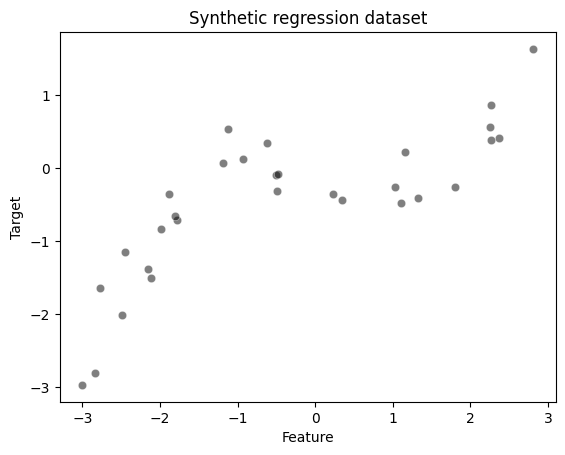

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x**3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"]
    )
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train



data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
_ = plt.title("Synthetic regression dataset")

In [6]:
# Train test

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

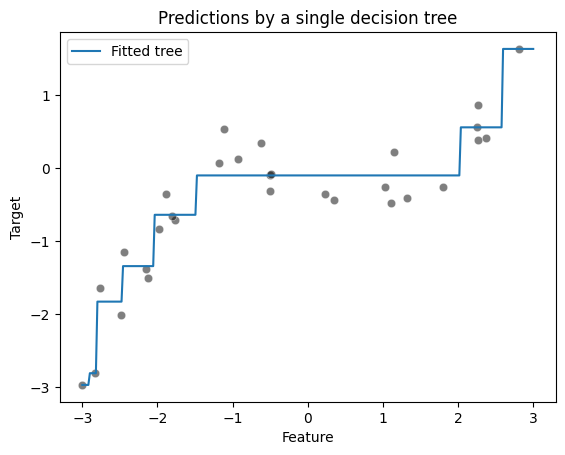

In [7]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

Let's see how we can use bootstraping to learn several trees.

## Bootstrap resampling

Given a dataset with `n` data points, bootstrapping corresponds to resampling
with replacement  `n` out of such `n` data points uniformly at random.

As a result, the output of the bootstrap sampling procedure is another dataset
with also n data points, but likely with duplicates. As a consequence, there
are also data points from the original dataset that are never selected to
appear in a bootstrap sample (by chance). Those data points that are left away
are often referred to as the out-of-bag sample.

We will create a function that given `data` and `target` will return a
resampled variation `data_bootstrap` and `target_bootstrap`.



## Aggregating

Once our trees are fitted, we are able to get predictions for each of them. In
regression, the most straightforward way to combine those predictions is just
to average them: for a given test data point, we feed the input feature values
to each of the `n` trained models in the ensemble and as a result compute `n`
predicted values for the target variable. The final prediction of the ensemble
for the test data point is the average of those `n` values.

We can plot the averaged predictions from the previous example.

## Bagging in scikit-learn

Scikit-learn implements the bagging procedure as a **meta-estimator**, that is,
an estimator that wraps another estimator: it takes a base model that is
cloned several times and trained independently on each bootstrap sample.

The following code snippet shows how to build a bagging ensemble of decision
trees. We set `n_estimators=100` instead of 3 in our manual implementation
above to get a stronger smoothing effect.

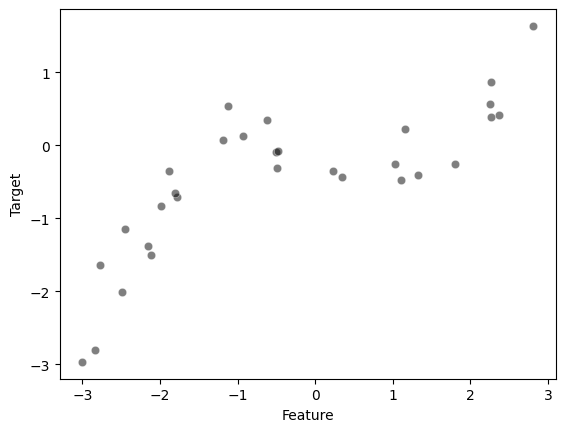

In [9]:
# Bagging Estimator

bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100
)

# Train the model
_ = bagged_trees.fit(data_train, target_train)

# Preview the data
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
);


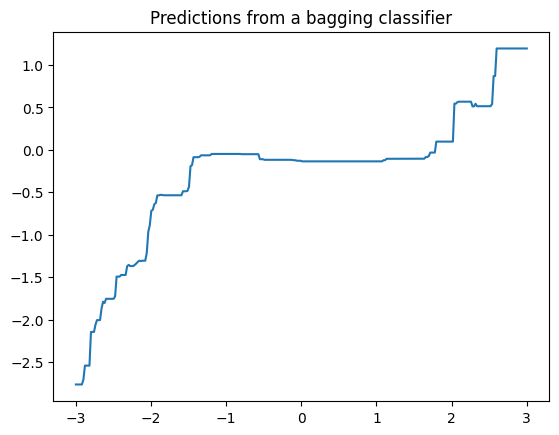

In [10]:
bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")


It is possible to access the internal models of the ensemble stored as a
Python list in the `bagged_trees.estimators_` attribute after fitting.

Let us compare the based model predictions with their average:

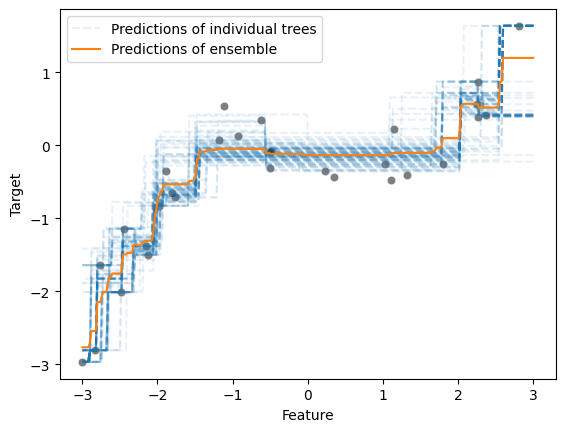

In [11]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.1,
        color="tab:blue",
        label=label,
    )

sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(
    data_test["Feature"],
    bagged_trees_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
_ = plt.legend()

A low value of the opacity parameter `alpha` is used to better appreciate the
overlap in the prediction functions of the individual trees.

This visualization gives some insights on the uncertainty in the predictions
in different areas of the feature space.

## Bagging complex pipelines

While we used a decision tree as a base model, nothing prevents us of using
any other type of model.

As we know that the original data generating function is a noisy polynomial
transformation of the input variable, let us try to fit a bagged polynomial
regression pipeline on this dataset:

In [12]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline


polynomial_regressor = make_pipeline(
    # Min max scaler
    MinMaxScaler(),
    # Polynomial features
    PolynomialFeatures(degree=4),
    # Ridge regression
    Ridge(alpha=1e-10)
)

# Using the Polynomial Regressor 
bagging_regressor = BaggingRegressor(
    estimator=polynomial_regressor,
    n_estimators=100,
    random_state=123
) 

_ = bagging_regressor.fit(data_train, target_train)

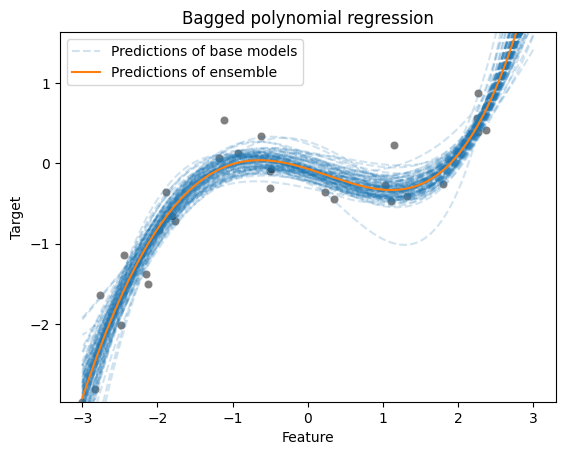

In [13]:
for i, regressor in enumerate(bagging_regressor.estimators_):
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    regressor_predictions = regressor.predict(data_test.to_numpy())
    base_model_line = plt.plot(
        data_test["Feature"],
        regressor_predictions,
        linestyle="--",
        alpha=0.2,
        label="Predictions of base models" if i == 0 else None,
        color="tab:blue",
    )

sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
bagging_predictions = bagging_regressor.predict(data_test)
plt.plot(
    data_test["Feature"],
    bagging_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")

The predictions of this bagged polynomial regression model looks qualitatively
better than the bagged trees.` This is somewhat expected since the base model
better reflects our knowledge of the trudata-generatingng proces`s.

Again the different shades induced by the overlapping blue lines let us
appreciate the uncertainty in the prediction of the bagged ensembBt the bootstrapping procedu e is a
generic tool of statistics and is not limited to build ensemble of machine
learningatistics)).

# Random Forests

Random forests are a popular model in machine learning. They are a
modification of the bagging algorithm. In bagging, any classifier or regressor
can be used. In random forests, the base classifier or regressor is always a
decision tree.

Random forests have another particularity: when training a tree, the search
for the best split is done only on a subset of the original features taken at
random. The random subsets are different for each split node. The goal is to
inject additional randomization into the learning procedure to try to
decorrelate the prediction errors of the individual trees.

Therefore, random forests are using **randomization on both axes of the data
matrix**:

- by **bootstrapping samples** for **each tree** in the forest;
- randomly selecting a **subset of features** at **each node** of the tree.

## A look at random forests

We will illustrate the usage of a random forest classifier on the adult census
dataset.

In [16]:
df_path = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/main/datasets/adult-census.csv'


df = pd.read_csv(df_path)


target_name = 'class'


# drop the target from the df

data = df.drop(columns=[target_name, "education-num"])

target = df['class']


In [17]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


pre_processor = make_column_transformer(
    # Categorical Encoding of Ordinal Variables
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object)),
    # Pass through all else
    remainder='passthrough'
)


# Creating a pipeline for a single Decision Tree
tree_pipe = make_pipeline(
    # insert pre-processor
    pre_processor,
    # Insert Cecision Tree
    DecisionTreeClassifier(random_state=123)
)


# Grab your cross_val score
scores_tree = cross_val_score(
    tree_pipe,
    data,
    target
)


print(
    "Decision tree classifier: "
    f"{scores_tree.mean():.3f} ± {scores_tree.std():.3f}"
)

Decision tree classifier: 0.820 ± 0.004


In [23]:
# Using the Bagging Classifier
from sklearn.ensemble import BaggingClassifier


bagging_trees = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=123),
    n_estimators=100,
    n_jobs=2,
    random_state=123
)

# Construct your pipeline with the model
bagged_trees_pipe = make_pipeline(
    # Insert pre-processor
    pre_processor,
    # insert_model
    bagging_trees
)

# Grab your cross_val score
scores_bagged_tree = cross_val_score(
    bagged_trees_pipe,
    data,
    target
)


print(
    "Bagged Trees Classifier: "
    f"{scores_bagged_tree.mean():.3f} ± {scores_bagged_tree.std():.3f}"
)

Bagged Trees Classifier: 0.846 ± 0.006


Note that the generalization performance of the bagged trees is already much
better than the performance of a single tree.

Now, we will use a random forest. You will observe that we do not need to
specify any `estimator` because the estimator is forced to be a decision tree.
Thus, we just specify the desired number of trees in the forest.

In [24]:
from sklearn.ensemble import RandomForestClassifier


rf_class = RandomForestClassifier(
    n_estimators=50,
    n_jobs=2,
    random_state=123
)


rf_pipe = make_pipeline(
    pre_processor,
    rf_class
)


# Grab your cross_val score
scores_rf_pipe = cross_val_score(
    rf_pipe,
    data,
    target
)


print(
    "Random Forest Classifier: "
    f"{scores_rf_pipe.mean():.3f} ± {scores_rf_pipe.std():.3f}"
)

Random Forest Classifier: 0.851 ± 0.004


It seems that the random forest is performing slightly better than the bagged
trees possibly due to the randomized selection of the features which
decorrelates the prediction errors of individual trees and as a consequence
make the averaging step more efficient at reducing overfitting.

## Details about default hyperparameters

For random forests, it is possible to control the amount of randomness for
each split by setting the value of `max_features` hyperparameter:

- `max_features=0.5` means that 50% of the features are considered at each
  split;
- `max_features=1.0` means that all features are considered at each split
  which effectively disables feature subsampling.

By default, `RandomForestRegressor` disables feature subsampling while
`RandomForestClassifier` uses `max_features=np.sqrt(n_features)`. These
default values reflect good practices given in the scientific literature.

However, `max_features` is one of the hyperparameters to consider when tuning
a random forest:
- too much randomness in the trees can lead to underfitted base models and can
  be detrimental for the ensemble as a whole,
- too few randomness in the trees leads to more correlation of the prediction
  errors and as a result reduce the benefits of the averaging step in terms of
  overfitting control.

In scikit-learn, the bagging classes also expose a `max_features` parameter.
However, `BaggingClassifier` and `BaggingRegressor` are agnostic with respect
to their base model and therefore random feature subsampling can only happen
once before fitting each base model instead of several times per base model as
is the case when adding splits to a given tree.

We summarize these details in the following table:

| Ensemble model class     | Base model class          | Default value for `max_features`   | Features subsampling strategy |
|--------------------------|---------------------------|------------------------------------|-------------------------------|
| `BaggingClassifier`      | User specified (flexible) | `n_features` (no&nbsp;subsampling) | Model level                   |
| `RandomForestClassifier` | `DecisionTreeClassifier`  | `sqrt(n_features)`                 | Tree node level               |
| `BaggingRegressor`       | User specified (flexible) | `n_features` (no&nbsp;subsampling) | Model level                   |
| `RandomForestRegressor`  | `DecisionTreeRegressor`   | `n_features` (no&nbsp;subsampling) | Tree node level               |

# Adaptive Boosting

In [29]:
df_path  = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/main/datasets/penguins_classification.csv'

df = pd.read_csv(df_path)

culmen_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)']

target_col = 'Species'


data, target = df[culmen_cols], df[target_col]

In [30]:
import seaborn as sns


palette = ['tab:red', 'tab:blue', 'black']


tree = DecisionTreeClassifier(max_depth=2, random_state=123)

# fit tree to data
tree.fit(data, target)

DecisionTreeClassifier(max_depth=2, random_state=123)

In [31]:
# Perform prediction on data and grab the misclassified records
target_pred = tree.predict(data)

misclassified_samples_idx = np.flatnonzero(target != target_pred)
data_misclassified = data.iloc[misclassified_samples_idx]

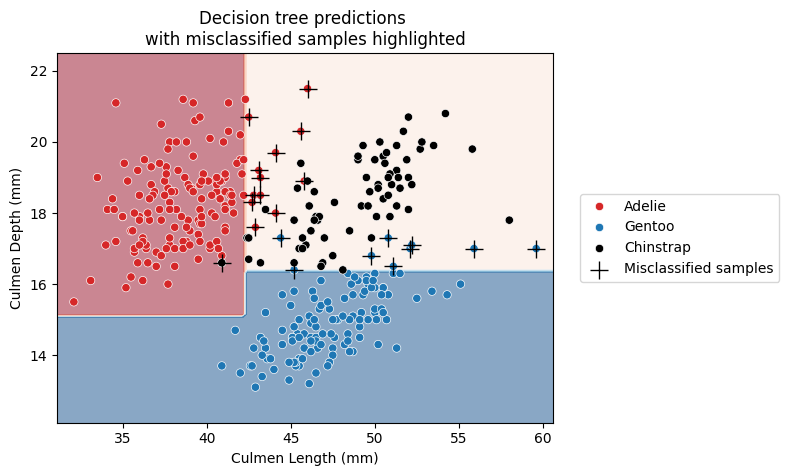

In [33]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    tree, data, response_method="predict", cmap="RdBu", alpha=0.5
)

# plot the original dataset
sns.scatterplot(
    data=df,
    x=culmen_cols[0],
    y=culmen_cols[1],
    hue=target_col,
    palette=palette,
)
# plot the misclassified samples
sns.scatterplot(
    data=data_misclassified,
    x=culmen_cols[0],
    y=culmen_cols[1],
    label="Misclassified samples",
    marker="+",
    s=150,
    color="k",
)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title(
    "Decision tree predictions \nwith misclassified samples highlighted"
)

Several samples have been misclassified.

We mentioned that boosting relies on creating a new classifier which tries to correct these misclassifications. In scikit-learn, learners have a parameter `sample_weight` which forces it to pay more attention to samples with higher weights during the training.


This parameter is set when calling `classifier.fit(X, y, sample_weight=weights)`. We will use this trick to create a new classifier by 'discarding' all correctly classified samples and only considering the misclassified samples. Thus, misclassified samples will be assigned a weight of 1 and well classified samples will be assigned a weight of 0

In [34]:
sample_weight = np.zeros_like(target, dtype=int)
sample_weight[misclassified_samples_idx] = 1

# Fit the tree with the sample_Weight
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target, sample_weight=sample_weight)


DecisionTreeClassifier(max_depth=2, random_state=0)

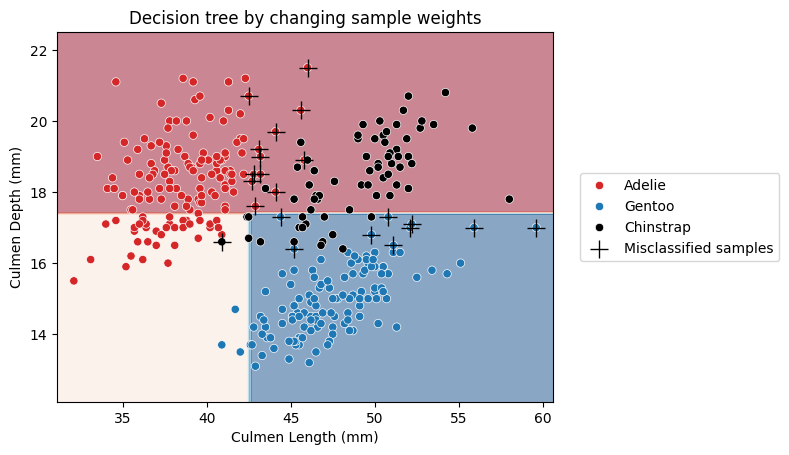

In [35]:
DecisionBoundaryDisplay.from_estimator(
    tree, data, response_method="predict", cmap="RdBu", alpha=0.5
)

# plot the original dataset
sns.scatterplot(
    data=df,
    x=culmen_cols[0],
    y=culmen_cols[1],
    hue=target_col,
    palette=palette,
)
# plot the misclassified samples
sns.scatterplot(
    data=data_misclassified,
    x=culmen_cols[0],
    y=culmen_cols[1],
    label="Misclassified samples",
    marker="+",
    s=150,
    color="k",
)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title(
    "Decision tree by changing sample weights"
)

In [36]:
target_predicted = tree.predict(data)
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(
    "Number of samples previously misclassified and "
    f"still misclassified: {len(remaining_misclassified_samples_idx)}"
)

Number of samples previously misclassified and still misclassified: 0


However, we are making mistakes on previously well classified samples. Thus, we get the intuition that we should weight the predictions of each classifier differently, most probably by using the number of mistakes each classifier is making.

So we could use the classification error to combine both trees.

In [37]:
ensemble_weight = [
    (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
    (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

The first classifier was 94% accurate and the second one 69% accurate. Therefore, when predicting a class, we should trust the first classifier slightly more than the second one. We could use these accuracy values to weight the predictions of each learner.

>To summarize, boosting learns several classifiers, each of which will focus more or less on specific samples of the dataset. Boosting is thus different from bagging: here we never resample our dataset, we just assign different weights to the original dataset.

Boosting requires some strategy to combine the learners together:

- one needs to define a way to compute the weights to be assigned to samples;
- one needs to assign a weight to each learner when making predictions.


Indeed, we defined a really simple scheme to assign sample weights and learner weights. However, there are statistical theories (like in AdaBoost) for how these sample and learner weights can be optimally calculated.

Lets now use AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier


estimator = DecisionTreeClassifier(max_depth=3, random_state=123)

adaboost = AdaBoostClassifier(
    estimator=estimator,
    n_estimators=3,
    algorithm='SAMME',
    random_state=123
)


adaboost.fit(data, target)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=123),
                   n_estimators=3, random_state=123)

<Figure size 640x480 with 0 Axes>

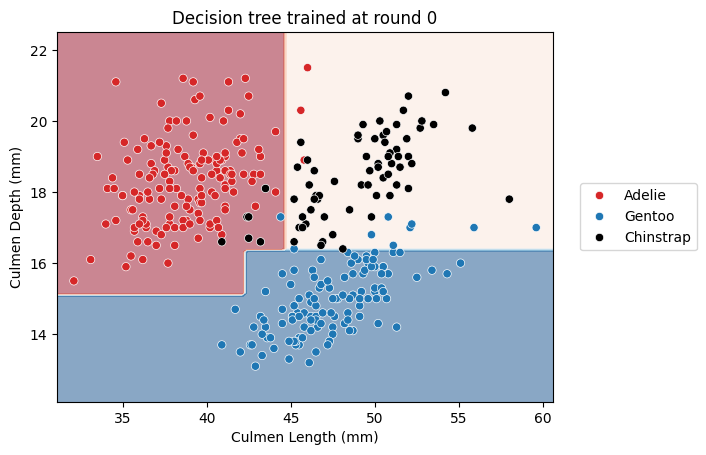

<Figure size 640x480 with 0 Axes>

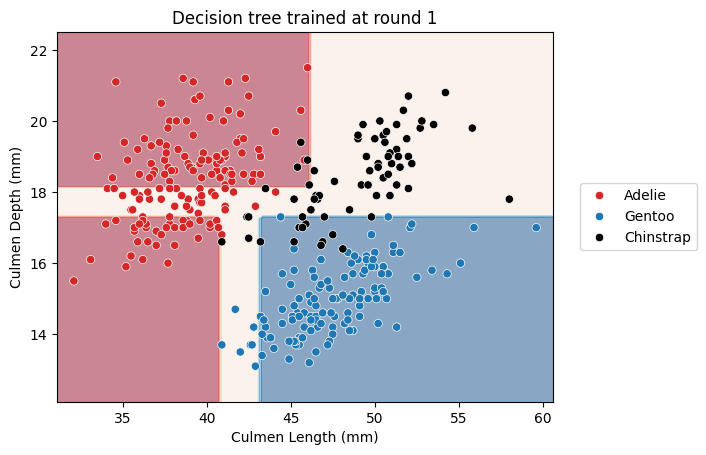

<Figure size 640x480 with 0 Axes>

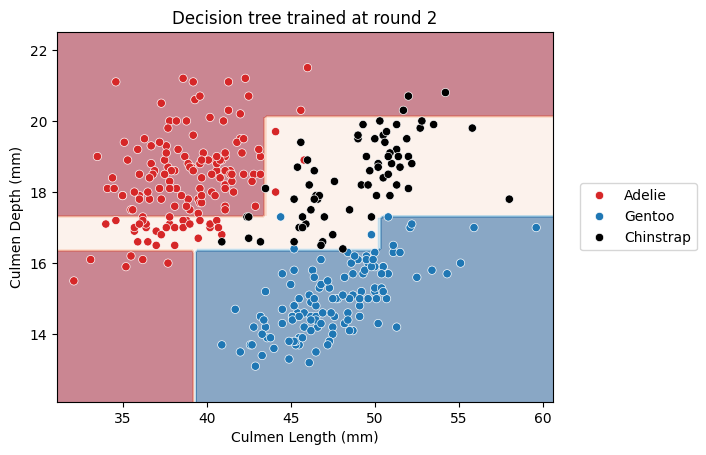

In [39]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    # we convert `data` into a NumPy array to avoid a warning raised in scikit-learn
    DecisionBoundaryDisplay.from_estimator(
        tree,
        data.to_numpy(),
        response_method="predict",
        cmap="RdBu",
        alpha=0.5,
    )
    sns.scatterplot(
        x=culmen_cols[0],
        y=culmen_cols[1],
        hue=target_col,
        data=df,
        palette=palette,
    )
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")
     

In [40]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [41]:
print(f"Error of each classifier: {adaboost.estimator_errors_}")

Error of each classifier: [0.05263158 0.05864198 0.08787269]


We see that AdaBoost learned three different classifiers, each of which focuses on different samples. Looking at the weights of each learner, we see that the ensemble gives the highest weight to the first classifier. This indeed makes sense when we look at the errors of each classifier. The first classifier also has the highest classification generalization performance.

While AdaBoost is a nice algorithm to demonstrate the internal machinery of boosting algorithms, it is not the most efficient.

# Speeding Boosting with Gradient Boosting and Histogram Gradient Boosting


In gradient-boosting, the algorithm is a sequential algorithm. It requires the N-1 trees to have been fit to be able to fit the tree at stage N. Therefore, the algorithm is quite computationally expensive. The most expensive part in this algorithm is the search for the best split in the tree which is a brute-force approach: all possible split are evaluated and the best one is picked. 

To accelerate the gradient-boosting algorithm, one could reduce the number of splits to be evaluated. As a consequence, the generalization performance of such a tree would be reduced. However, since we are combining several trees in a gradient-boosting, we can add more estimators to overcome this issue.

In [42]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting,
    data,
    target,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)



print("Histogram Gradient Boosting Decision Tree")
print(
    "Mean absolute error via cross-validation: "
    f"{-cv_results_gbdt['test_score'].mean():.3f} ± "
    f"{cv_results_gbdt['test_score'].std():.3f} k$"
)
print(f"Average fit time: {cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(
    f"Average score time: {cv_results_gbdt['score_time'].mean():.3f} seconds"
)
   

Histogram Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.443 ± 2.913 k$
Average fit time: 21.924 seconds
Average score time: 0.017 seconds


Scikit-learn provides specific classes which are even more optimized for large dataset, called `HistGradientBoostingClassifier` and `HistGradientBoostingRegressor`. Each feature in the dataset data is first binned by computing histograms, which are later used to evaluate the potential splits. The number of splits to evaluate is then much smaller. This algorithm becomes much more efficient than gradient boosting when the dataset has over 10,000 samples.

In [44]:
from sklearn.ensemble import HistGradientBoostingRegressor


hist_grad_booster = HistGradientBoostingRegressor(
    max_iter=200,
    random_state=123
)


cv_results = cross_validate(
    hist_grad_booster,
    data,
    target,
    scoring='neg_mean_absolute_error',
    n_jobs=2
)


print("Histogram Gradient Boosting Decision Tree")
print(
    "Mean absolute error via cross-validation: "
    f"{-cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f} k$"
)
print(f"Average fit time: {cv_results['fit_time'].mean():.3f} seconds")
print(
    f"Average score time: {cv_results['score_time'].mean():.3f} seconds"
)
   

Histogram Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 44.432 ± 3.283 k$
Average fit time: 1.711 seconds
Average score time: 0.031 seconds


The histogram gradient booster is the performer and scales better than AdaBoost

# Hyperparameter Tuning of Random Forest and HistGradient Boosting



In [47]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

## Random Forest



The main parameter to select in random forest is the `n_estimators` parameter.
In general, the more trees in the forest, the better the generalization
performance would be. However, adding trees slows down the fitting and prediction
time. The goal is to balance computing time and generalization performance
when setting the number of estimators. Here, we fix `n_estimators=100`, which
is already the default value.


<div class="admonition caution alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Caution!</p>
<p class="last">Tuning the <tt class="docutils literal">n_estimators</tt> for random forests generally result in a waste of
computer power. We just need to ensure that it is large enough so that doubling
its value does not lead to a significant improvement of the validation error.</p>
</div>

Instead, we can tune the hyperparameter `max_features`, which controls the
size of the random subset of features to consider when looking for the best
split when growing the trees: smaller values for `max_features` lead to
more random trees with hopefully more uncorrelated prediction errors. However
if `max_features` is too small, predictions can be too random, even after
averaging with the trees in the ensemble.

If `max_features` is set to `None`, then this is equivalent to setting
`max_features=n_features` which means that the only source of randomness in
the random forest is the bagging procedure.

We can also tune the different parameters that control the depth of each tree
in the forest. Two parameters are important for this: `max_depth` and
`max_leaf_nodes`. They differ in the way they control the tree structure.
Indeed, `max_depth` enforces growing symmetric trees, while `max_leaf_nodes`
does not impose such constraint. If `max_leaf_nodes=None` then the number of
leaf nodes is unlimited.

The hyperparameter `min_samples_leaf` controls the minimum number of samples
required to be at a leaf node. This means that a split point (at any depth) is
only done if it leaves at least `min_samples_leaf` training samples in each of
the left and right branches. A small value for `min_samples_leaf` means that
some samples can become isolated when a tree is deep, promoting overfitting. A
large value would prevent deep trees, which can lead to underfitting.

Be aware that with random forest, trees are expected to be deep since we are
seeking to overfit each tree on each bootstrap sample. Overfitting is
mitigated when combining the trees altogether, whereas assembling underfitted
trees (i.e. shallow trees) might also lead to an underfitted forest.

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


param_dist = {
    "max_features": [1, 2, 3, 5, None],
    "max_leaf_nodes": [10, 100, 1000, None],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
}

# Get the best Hyperparams
tuned_rf = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2, random_state=123),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    n_iter=10,
    random_state=123,
    n_jobs=2,
    cv=10
)


# Fitting the tuned RF into the outer tuning
cv_results = cross_validate(
    tuned_rf,
    data,
    target,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
    return_estimator=True,
    cv=10
)

In [55]:

# Preview the params
columns = [f"param_{name}" for name in param_dist.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(cv_results)

cv_results.head()

,fit_time,score_time,estimator,test_score
0,445.647314,0.031315,"RandomizedSearchCV(cv=10,\n ...",-64.633352
1,449.790442,0.033598,"RandomizedSearchCV(cv=10,\n ...",-44.392076
2,457.466328,0.032124,"RandomizedSearchCV(cv=10,\n ...",-46.046559
3,468.673862,0.031887,"RandomizedSearchCV(cv=10,\n ...",-32.992449
4,456.605834,0.030483,"RandomizedSearchCV(cv=10,\n ...",-46.419647


We can observe in our search that we are required to have a large number of
`max_leaf_nodes` and thus deep trees. This parameter seems particularly
impactful with respect to the other tuning parameters, but large values of
`min_samples_leaf` seem to reduce the performance of the model.

In practice, more iterations of random search would be necessary to precisely
assert the role of each parameters. Using `n_iter=10` is good enough to
quickly inspect the hyperparameter combinations that yield models that work
well enough without spending too much computational resources. Feel free to
try more interations on your own.

Once the `RandomizedSearchCV` has found the best set of hyperparameters, it
uses them to refit the model using the full training set. To estimate the
generalization performance of the best model it suffices to call `.score` on
the unseen data.

In [72]:
[print((est.best_params_)) for est in cv_results['estimator']]


{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}
{'min_samples_leaf': 5, 'max_leaf_nodes': 1000, 'max_features': None}


[None, None, None, None, None, None, None, None, None, None]

In [56]:
print(
    "Mean absolute error of the  via cross-validation: "
    f"{-cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f} k$"
)

Mean absolute error of the  via cross-validation: 45.795 ± 10.583 k$


## Histogram gradient-boosting decision trees

For gradient-boosting, hyperparameters are coupled, so we cannot set them
one after the other anymore. The important hyperparameters are `max_iter`,
`learning_rate`, and `max_depth` or `max_leaf_nodes` (as previously discussed
random forest).

Let's first discuss `max_iter` which, similarly to the `n_estimators`
hyperparameter in random forests, controls the number of trees in the
estimator. The difference is that the actual number of trees trained by the
model is not entirely set by the user, but depends also on the stopping
criteria: the number of trees can be lower than `max_iter` if adding a new
tree does not improve the model enough. We will give more details on this in
the next exercise.

The depth of the trees is controlled by `max_depth` (or `ma in the ensemble. Thus, fitting fully grown trees would be
detrimental. Indeed, the first tree of the ensemble would perfectly fit
(overfit) the data and thus no subsequent tree would be required, since there
would be no residuals. Therefore, the tree used in gradient-boosting should
have a low depth, typically between 3 to 8 levels, or few leaves ($2^3=8$ to
$2^8=256$). Having very weak learners at each step helps reducing overfitting.

With this consideration in mind, the deeper the trees, the faster the
residuals are corrected and then less learners are required. Therefore,
it can be beneficial to increase `max_iter` if `max_depth` is low.

Finally, we have overlooked the impact of the `learning_rate` parameter until
now. When fitting the residuals, we would like the tree to try to correct all
possible errors or only a fraction of them. The learning-rate allows you to
control this behaviour. A small learning-rate value would only correct the
residuals of very few samples. If a large learning-rate is set (e.g., 1), we
would fit the residuals of all samples. So, with a very low learning-rate, we
would need more estimators to correct the overall error. However, a too large
learning-rate tends to obtain an overfitted ensemble, similar to having very
deep trees.

In [74]:
from scipy.stats import loguniform
from sklearn.ensemble import HistGradientBoostingRegressor

param_dist = {
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}

# Get the best Hyperparams
tuned_hgbr = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=123),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    n_iter=10,
    random_state=123,
    n_jobs=2,
    cv=10
)


# Fitting the tuned RF into the outer tuning
cv_results = cross_validate(
    tuned_rf,
    data,
    target,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
    cv=10,
    return_estimator=True
)

KeyboardInterrupt: 

In [75]:

# # Preview the params
# pd.DataFrame(cv_results)

# # Preview pest params for each fold

# [print((est.get_params)) for est in cv_results['estimator']]


In [ ]:
print(
    "Mean absolute error of the HGBR via cross-validation: "
    f"{-cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f} k$"
)

e.

We summarize these details in the following table:

| **Bagging & Random Forests**                     | **Boosting**                                        |
|--------------------------------------------------|-----------------------------------------------------|
| fit trees **independently**                      | fit trees **sequentially**                          |
| each **deep tree overfits**                      | each **shallow tree underfits**                     |
| averaging the tree predictions **reduces overfitting** | sequentially adding trees **reduces underfitting** |
| generalization improves with the number of trees | too many trees may cause overfitting                |
| does not have a `learning_rate` parameter        | fitting the residuals is controlled by the `learning_rate` |

# Wrap Up Quiz 

In [76]:
# Grab your path
df_path = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/main/datasets/penguins.csv'

dataset = pd.read_csv(df_path)

feature_names = [
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
]
target_name = "Body Mass (g)"

dataset = dataset[feature_names + [target_name]].dropna(axis="rows", how="any")
dataset = dataset.sample(frac=1, random_state=0).reset_index(drop=True)
data, target = dataset[feature_names], dataset[target_name]

In [77]:
data.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm)
0,39.6,18.1,186.0
1,46.1,18.2,178.0
2,37.5,18.5,199.0
3,45.2,17.8,198.0
4,39.2,19.6,195.0


In [78]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# Initializing the decision tree regressor
dec_tree_reg = DecisionTreeRegressor(random_state=0)

# Performing CV
cv_res_dt = cross_validate(
    dec_tree_reg,
    data,
    target,
    cv=10,
    return_estimator=True,
    return_train_score=True
)


cv_res_dt = pd.DataFrame(cv_res_dt)

cv_res_dt

,fit_time,score_time,estimator,test_score,train_score
0,0.022652,0.005210,DecisionTreeRegressor(random_state=0),0.596506,1.0
1,0.003516,0.001997,DecisionTreeRegressor(random_state=0),0.669577,1.0
2,0.004172,0.001436,DecisionTreeRegressor(random_state=0),0.719311,1.0
3,0.005088,0.001156,DecisionTreeRegressor(random_state=0),0.818421,1.0
4,0.003011,0.001323,DecisionTreeRegressor(random_state=0),0.624282,1.0
5,0.003000,0.001000,DecisionTreeRegressor(random_state=0),0.724832,1.0
6,0.001999,0.002234,DecisionTreeRegressor(random_state=0),0.530907,1.0
7,0.002515,0.001000,DecisionTreeRegressor(random_state=0),0.516554,1.0
8,0.003000,0.001000,DecisionTreeRegressor(random_state=0),0.584218,1.0
9,0.003576,0.001088,DecisionTreeRegressor(random_state=0),0.490381,1.0


In [79]:
# Initializing the Random Forrest regressor
rf_reg =  RandomForestRegressor(random_state=0)

# Performing CV
cv_res_rf = cross_validate(
    rf_reg,
    data,
    target,
    cv=10,
    return_estimator=True,
    return_train_score=True
)


cv_res_rf = pd.DataFrame(cv_res_rf)

cv_res_rf

,fit_time,score_time,estimator,test_score,train_score
0,0.240965,0.006254,"(DecisionTreeRegressor(max_features=1.0, rando...",0.788125,0.971039
1,0.205831,0.005001,"(DecisionTreeRegressor(max_features=1.0, rando...",0.774361,0.971435
2,0.198097,0.007209,"(DecisionTreeRegressor(max_features=1.0, rando...",0.888714,0.972100
3,0.206253,0.005915,"(DecisionTreeRegressor(max_features=1.0, rando...",0.846614,0.971963
4,0.202224,0.005997,"(DecisionTreeRegressor(max_features=1.0, rando...",0.780436,0.972984
5,0.213342,0.005671,"(DecisionTreeRegressor(max_features=1.0, rando...",0.857715,0.971735
6,0.200920,0.005516,"(DecisionTreeRegressor(max_features=1.0, rando...",0.791857,0.973291
7,0.197993,0.005537,"(DecisionTreeRegressor(max_features=1.0, rando...",0.735433,0.973948
8,0.206256,0.005613,"(DecisionTreeRegressor(max_features=1.0, rando...",0.764853,0.972440
9,0.211215,0.004987,"(DecisionTreeRegressor(max_features=1.0, rando...",0.807753,0.971964


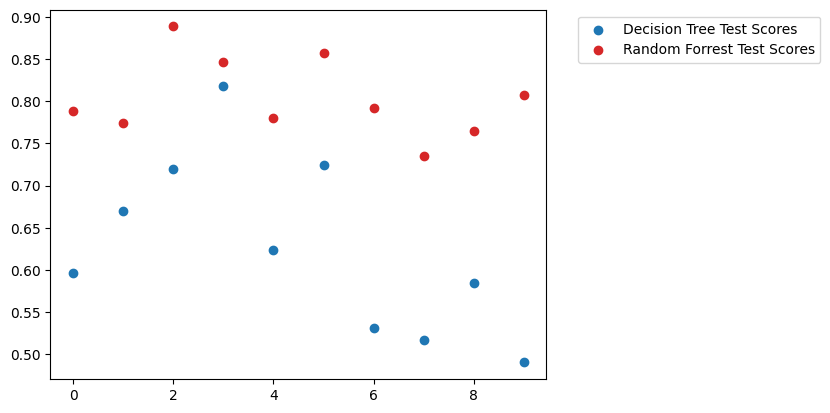

In [80]:
# Comparing DT to RF
dt_test_score = cv_res_dt['test_score']

rf_test_score = cv_res_rf['test_score']


plt.scatter(
    dt_test_score.index, 
    dt_test_score, 
    color="tab:blue", 
    label="Decision Tree Test Scores"
)


plt.scatter(
    rf_test_score.index,
    rf_test_score,
    color="tab:red",
    label="Random Forrest Test Scores",
);


_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [81]:
# RF with 5 DT
rf_reg_five_dt = RandomForestRegressor(
    n_estimators=5,
    random_state=0
)



# Performing CV
cv_res_rf_five_dt = cross_validate(
    rf_reg_five_dt,
    data,
    target,
    cv=10,
    return_estimator=True,
    return_train_score=True
)


cv_res_rf_five_dt = pd.DataFrame(cv_res_rf_five_dt)

cv_res_rf_five_dt

,fit_time,score_time,estimator,test_score,train_score
0,0.013211,0.002000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.772352,0.945006
1,0.010000,0.002001,"(DecisionTreeRegressor(max_features=1.0, rando...",0.658027,0.951393
2,0.012000,0.003000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.858495,0.954853
3,0.013999,0.003000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.820291,0.949372
4,0.011999,0.002000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.789220,0.953350
5,0.015033,0.002982,"(DecisionTreeRegressor(max_features=1.0, rando...",0.851265,0.952742
6,0.018124,0.001996,"(DecisionTreeRegressor(max_features=1.0, rando...",0.778812,0.951164
7,0.016001,0.002001,"(DecisionTreeRegressor(max_features=1.0, rando...",0.614453,0.946456
8,0.011035,0.001000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.764532,0.944864
9,0.012000,0.002000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.761193,0.948981


In [82]:
# RF with 5 DT
rf_reg_hun_dt = RandomForestRegressor(
    n_estimators=100,
    random_state=0
)



# Performing CV
cv_res_rf_hun_dt = cross_validate(
    rf_reg_hun_dt,
    data,
    target,
    cv=10,
    return_estimator=True,
    return_train_score=True
)


cv_res_rf_hun_dt = pd.DataFrame(cv_res_rf_hun_dt)

cv_res_rf_hun_dt

,fit_time,score_time,estimator,test_score,train_score
0,0.240970,0.007926,"(DecisionTreeRegressor(max_features=1.0, rando...",0.788125,0.971039
1,0.241397,0.008000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.774361,0.971435
2,0.232178,0.012004,"(DecisionTreeRegressor(max_features=1.0, rando...",0.888714,0.972100
3,0.214278,0.005000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.846614,0.971963
4,0.218934,0.007001,"(DecisionTreeRegressor(max_features=1.0, rando...",0.780436,0.972984
5,0.211287,0.004000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.857715,0.971735
6,0.208848,0.007000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.791857,0.973291
7,0.201687,0.004937,"(DecisionTreeRegressor(max_features=1.0, rando...",0.735433,0.973948
8,0.177194,0.005001,"(DecisionTreeRegressor(max_features=1.0, rando...",0.764853,0.972440
9,0.194620,0.006000,"(DecisionTreeRegressor(max_features=1.0, rando...",0.807753,0.971964


RF with 100 DT is substantially better than RF with 5 DTs by 9 out of 10


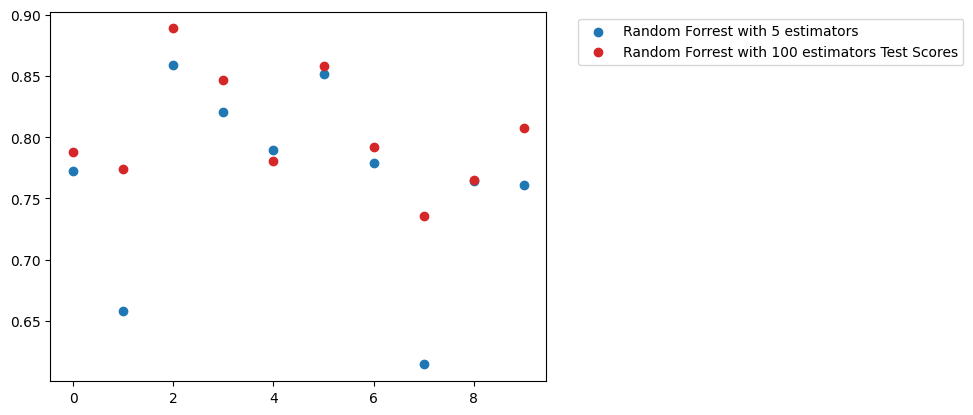

In [86]:
# Comparing DT to RF
cv_res_rf_five_dt_test_score = cv_res_rf_five_dt['test_score']

cv_res_rf_hun_dt_test_score = cv_res_rf_hun_dt['test_score']


plt.scatter(
    cv_res_rf_five_dt_test_score.index, 
    cv_res_rf_five_dt_test_score, 
    color="tab:blue", 
    label="Random Forrest with 5 estimators"
)


plt.scatter(
    cv_res_rf_hun_dt_test_score.index,
    cv_res_rf_hun_dt_test_score,
    color="tab:red",
    label="Random Forrest with 100 estimators Test Scores",
);


_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


print(
    'RF with 100 DT is substantially better than RF with 5 DTs by '
    f'{sum(cv_res_rf_hun_dt_test_score > cv_res_rf_five_dt_test_score)} out of 10'
)

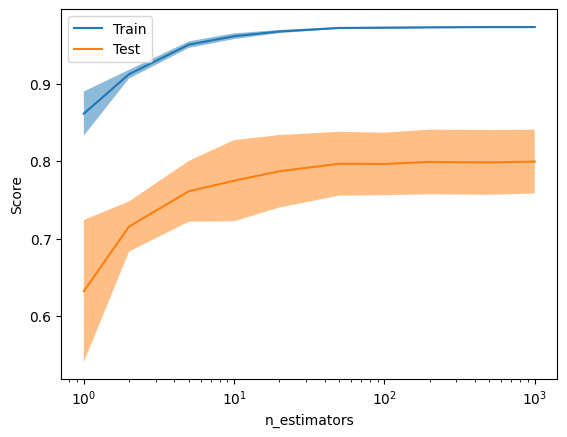

In [92]:
# Validation curve
from sklearn.model_selection import ValidationCurveDisplay


rf_full_dpth = RandomForestRegressor(
    random_state=0
)


disp = ValidationCurveDisplay.from_estimator(
    rf_full_dpth,
    data,
    target,
    param_name='n_estimators',
    param_range=np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]),
    score_type='both',
    n_jobs=2
)

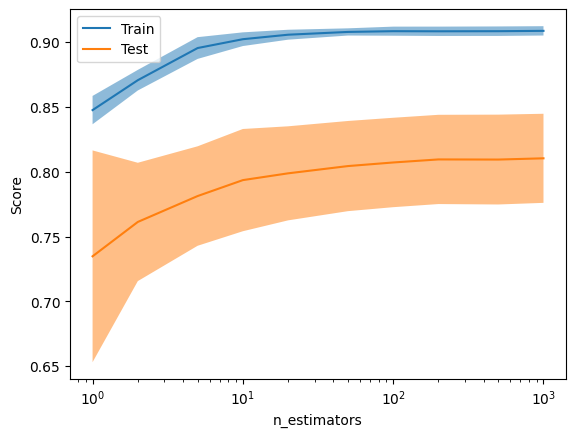

In [91]:
# Plotting the validation curve

rf_reg_mx_dpth = RandomForestRegressor(
    random_state=0,
    max_depth=5
)

disp = ValidationCurveDisplay.from_estimator(
    rf_reg_mx_dpth,
    data,
    target,
    param_name='n_estimators',
    param_range=np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]),
    score_type='both',
    n_jobs=2
)

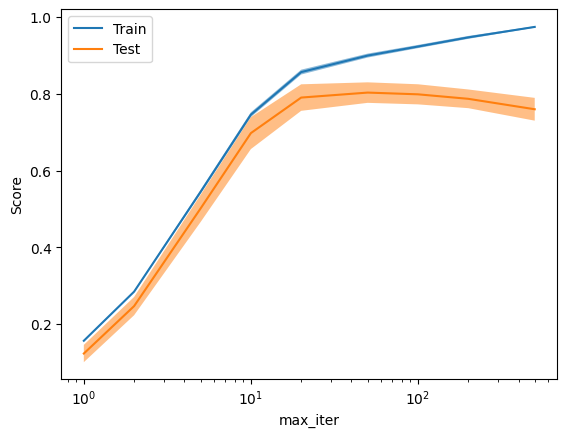

In [96]:
from sklearn.ensemble import HistGradientBoostingRegressor


hgb_reg = HistGradientBoostingRegressor(
    random_state=0
)



disp = ValidationCurveDisplay.from_estimator(
    hgb_reg,
    data,
    target,
    param_name='max_iter',
    param_range=np.array([1, 2, 5, 10, 20, 50, 100, 200, 500]),
    score_type='both',
    n_jobs=2
)